# Subpopulations Meta-Learning Distributions

In [1]:
from os import makedirs
from os.path import join

import pandas as pd

from common import ALIASES, filter_mset, plot_coocc, read_toml

In [2]:
config = read_toml('config.toml')
metachest_dir = config['metachest_dir']
df = pd.read_csv(join(metachest_dir, 'metachest.csv'))

mclasses = {'mtrn': config['mtrn'], 'mval': config['mval'], 'mtst': config['mtst']}
mset_dfs = [filter_mset(mset, mclasses, df)
            for mset in mclasses.keys()]

In [3]:
def age_mask(df, val):
    if val == 'center':
        a_left, a_right = [31, 62]
        mask = df['age'].between(a_left, a_right, inclusive='both')
    else:
        (a_left, a_right), (b_left, b_right) = [10, 30], [63, 80]
        mask = (df['age'].between(a_left, a_right, inclusive='both')|
                df['age'].between(b_left, b_right, inclusive='both'))
    return mask


def sex_mask(df, val):
    return df['sex'] == val[:1]


def view_mask(df, val):
    return df['view'] == val


subpops = [
    # name      val         mask
    ['age',     'center',   age_mask],
    ['age',     'tails',    age_mask],
    ['sex',     'female',   sex_mask],
    ['sex',     'male',     sex_mask],
    ['view',    'ap',       view_mask],
    ['view',    'pa',       view_mask]
]

distro_dir = join(metachest_dir, 'distro')
makedirs(distro_dir, exist_ok=True)

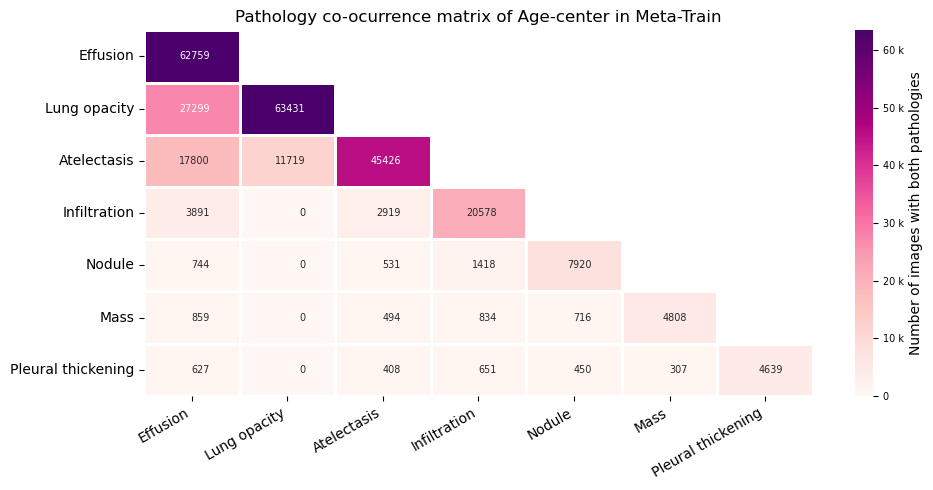

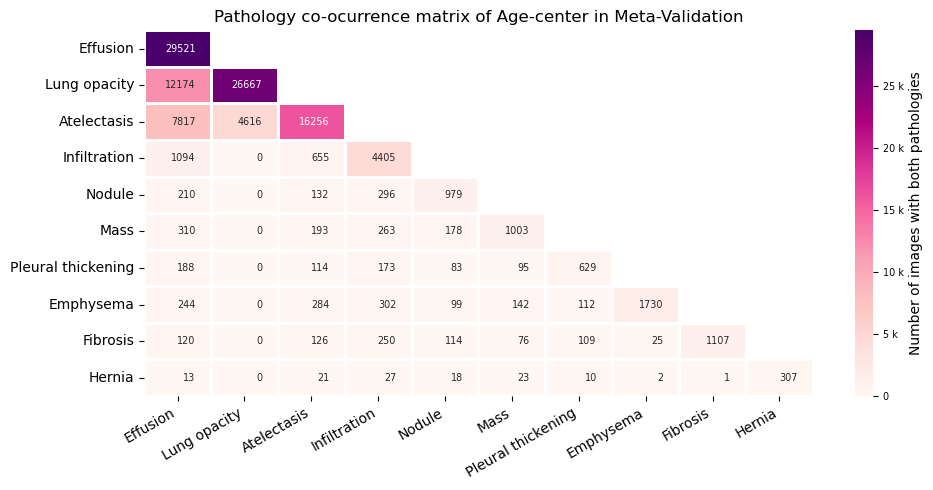

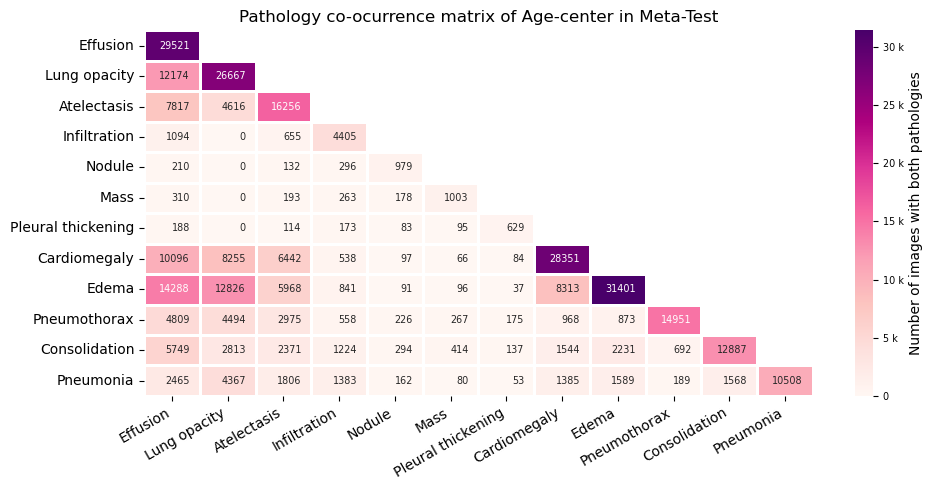

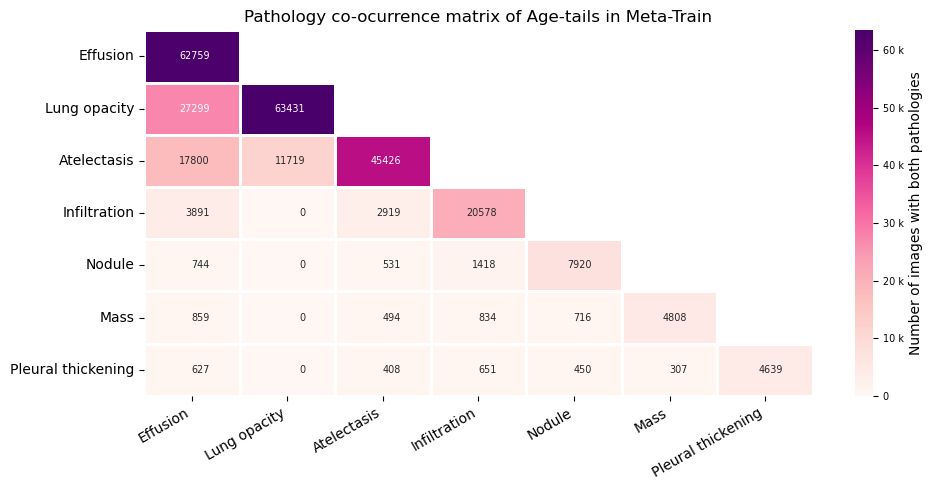

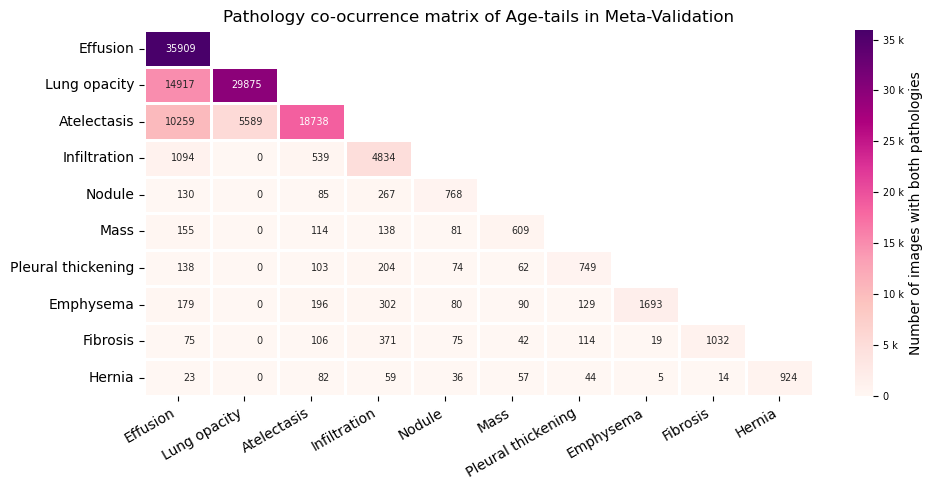

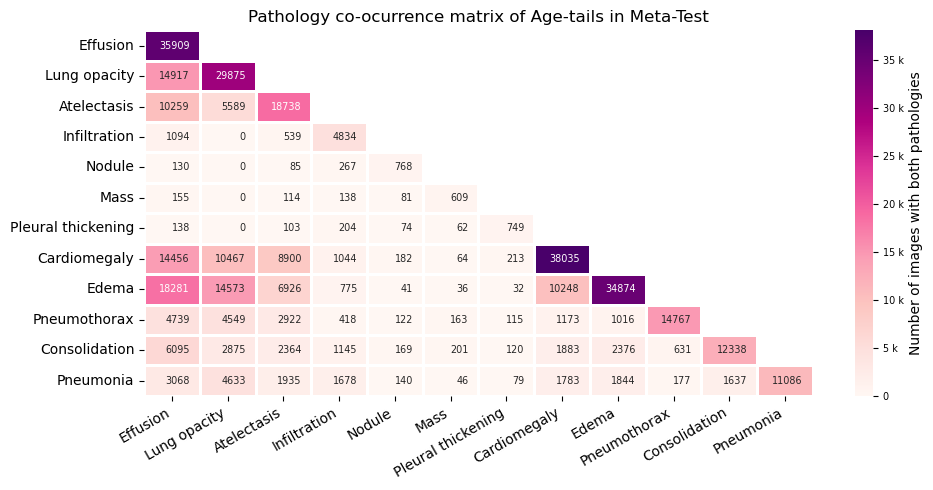

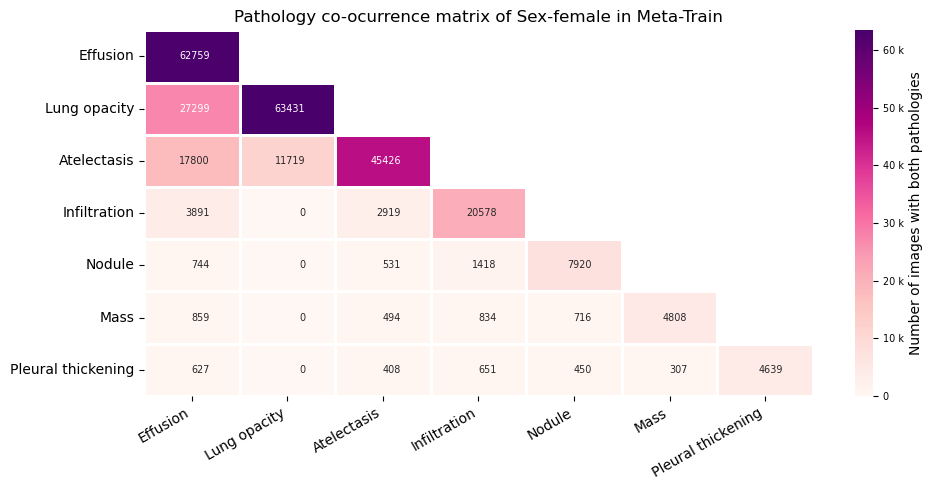

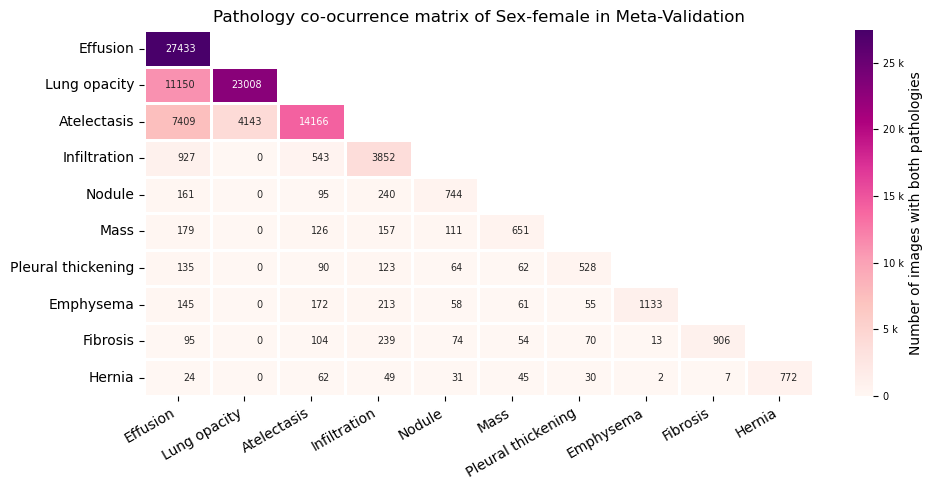

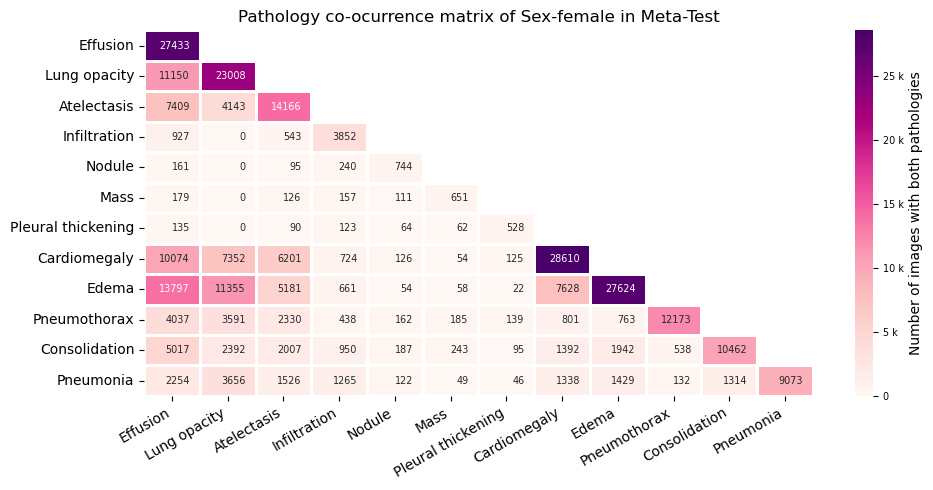

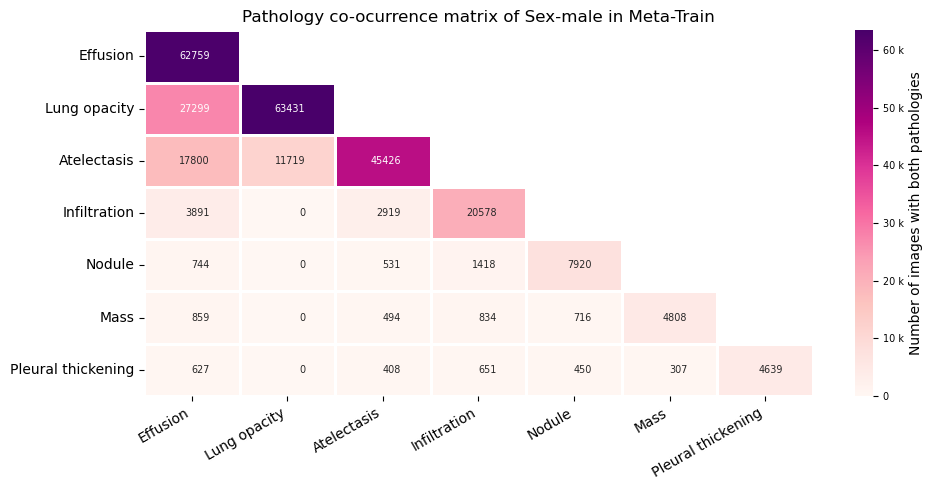

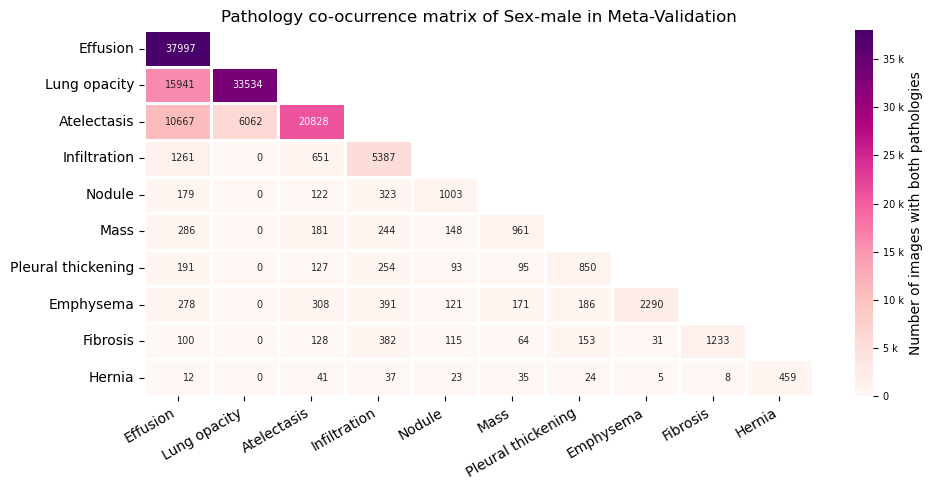

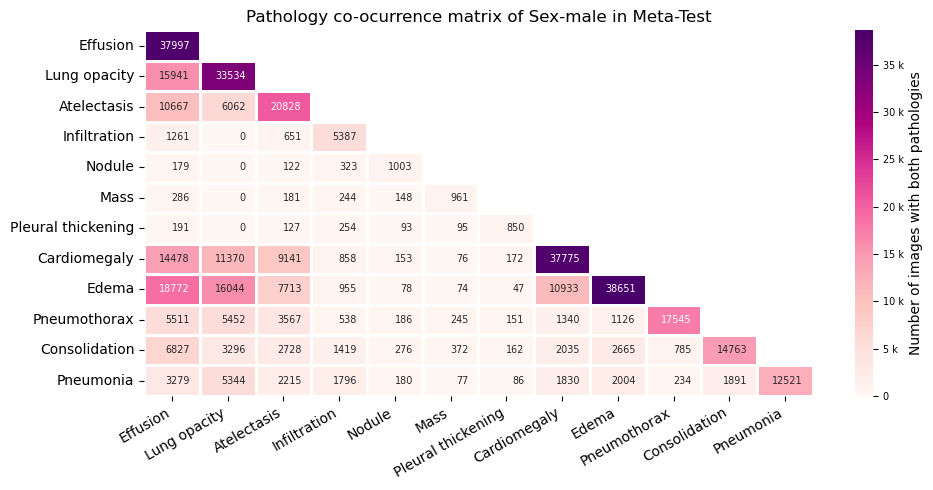

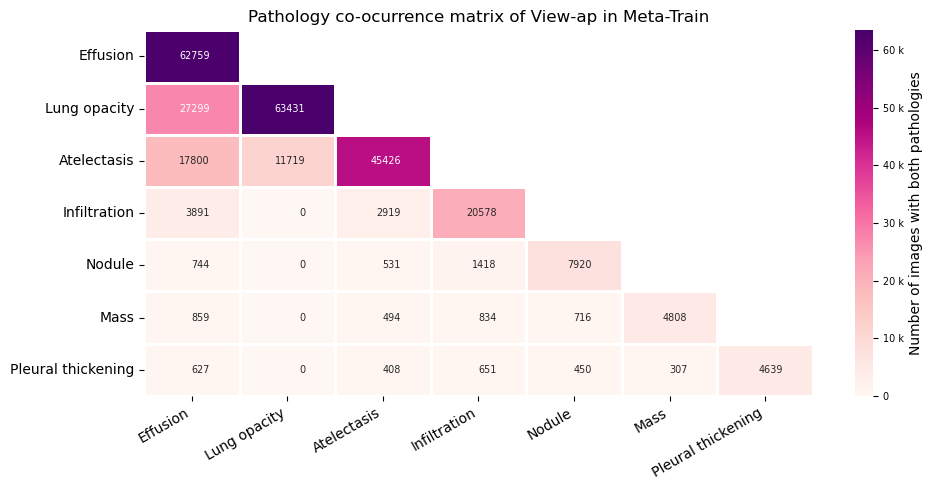

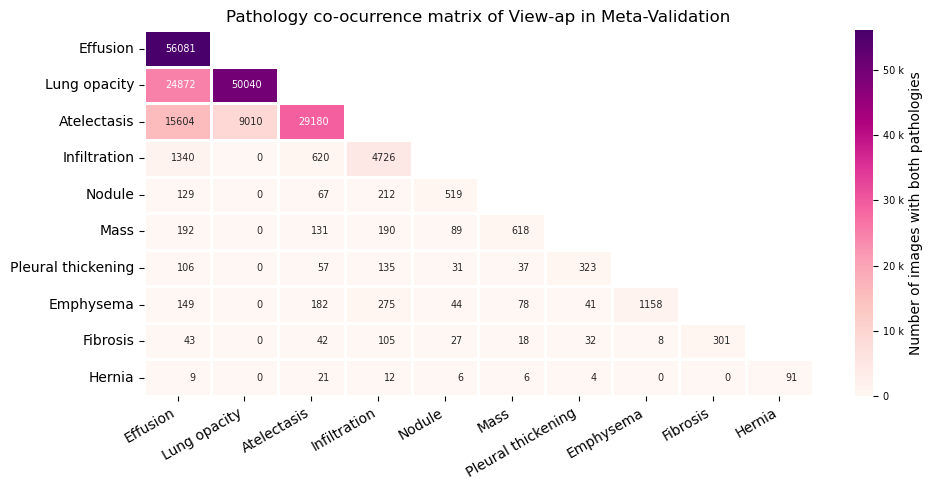

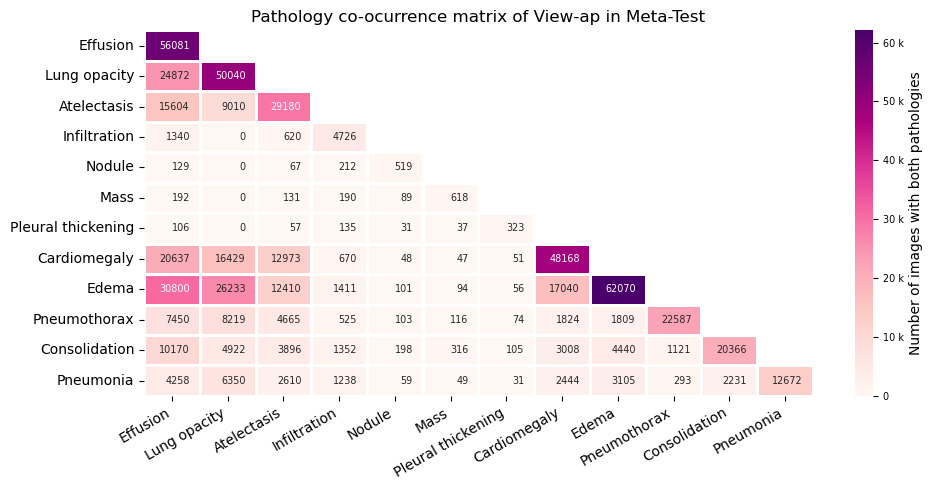

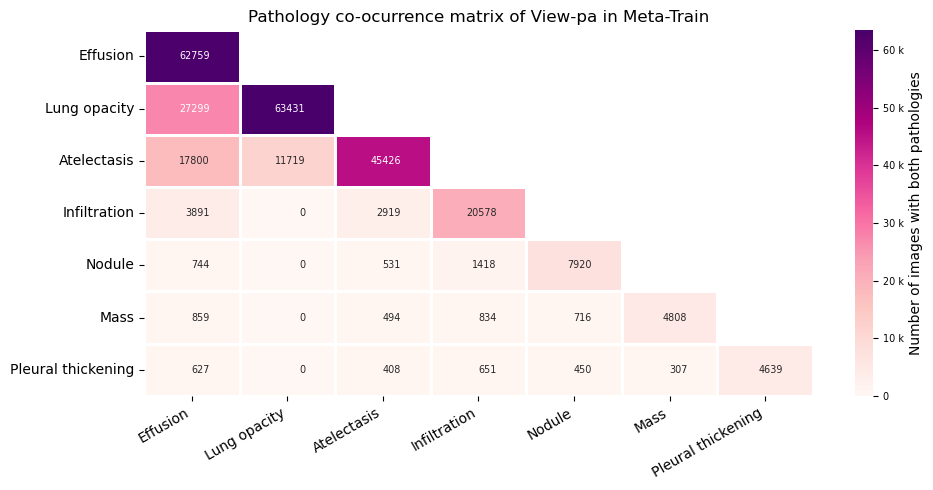

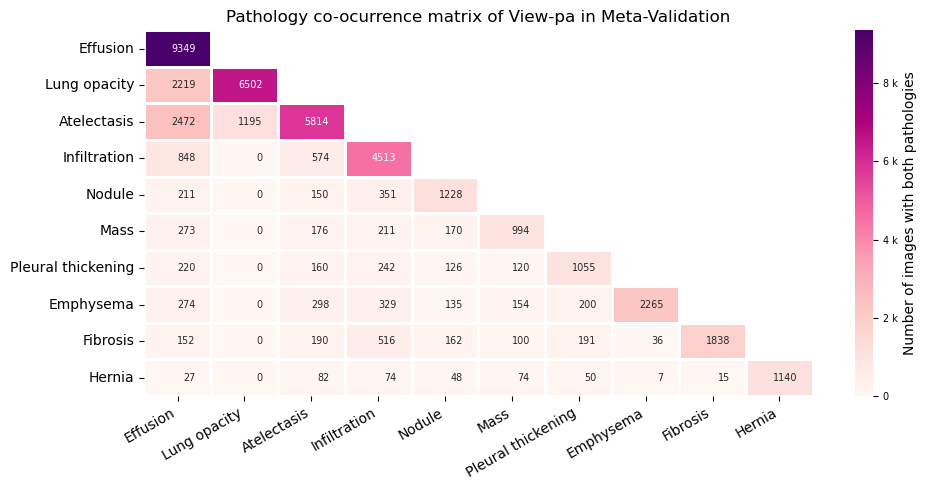

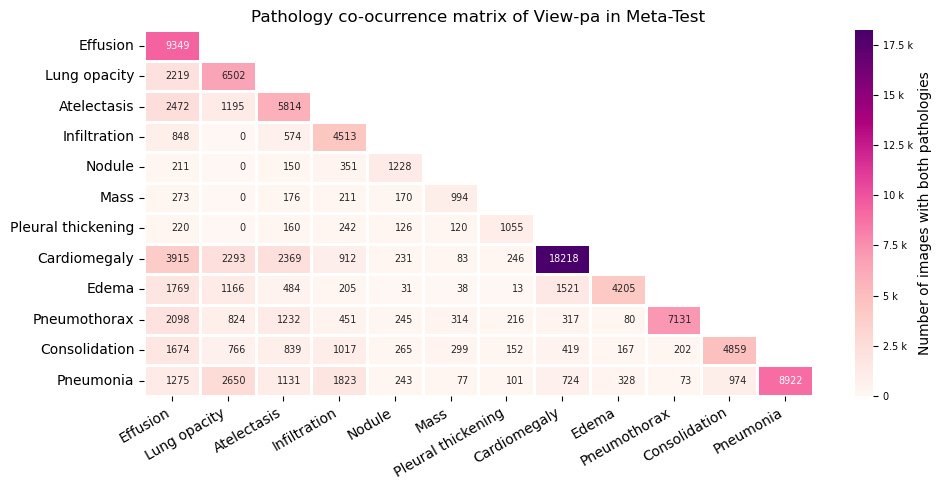

In [4]:
for name, val, fn_mask in subpops:
    mask = fn_mask(df, val)
    distro_df = pd.DataFrame({
        'mtrn': [1] * mask.shape[0],
        'mval': mask,
        'mtst': mask,
    }).astype(int)
    path = join(distro_dir, f'{name}_{val}.csv')
    distro_df.to_csv(path, index=False)

    dataset_title = f'{ALIASES[name]}-{val}'
    for mset, mset_df in zip(mclasses.keys(), mset_dfs):
        mask = distro_df[mset].astype(bool)
        ds_mset_df = mset_df.loc[mask]
        plot_coocc(dataset_title, mset, ds_mset_df.iloc[:, 5:])

### No-finding

In [5]:
nf_df = pd.read_csv(join(metachest_dir, 'metachest_nf.csv'))

for name, val, fn_mask in subpops:
    nf_distro = ( (nf_df.mset == 0) |
                 ((nf_df.mset == 1) & fn_mask(nf_df, val)) |
                 ((nf_df.mset == 2) & fn_mask(nf_df, val)))
    nf_distro = nf_distro.rename('mask').to_frame().astype(int)
    path = join(distro_dir, f'{name}_{val}_nf.csv')
    nf_distro.to_csv(path, index=False)
    print(path)

/data/datasets/metachest/distro/age_center_nf.csv
/data/datasets/metachest/distro/age_tails_nf.csv
/data/datasets/metachest/distro/sex_female_nf.csv
/data/datasets/metachest/distro/sex_male_nf.csv
/data/datasets/metachest/distro/view_ap_nf.csv
/data/datasets/metachest/distro/view_pa_nf.csv
